# Fine Tune the AlephBert model for Hebrew Sentence Similarity

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting the path for our model and dataset

In [16]:
#path to location where the notebook and the dataset is saved
#%cd /content/drive/MyDrive/תואר שני/פרויקט גמר/Training
# %cd /content/drive/MyDrive/Robohon
%cd /content/drive/MyDrive/תואר שני/פרויקט גמר/Model Training

/content/drive/MyDrive/תואר שני/פרויקט גמר/Model Training


## Install the transformers



In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 35.4 MB/s 
     |████████████████████████████████| 7.6 MB 43.3 MB/s 
     |████████████████████████████████| 182 kB 78.6 MB/s 


In [17]:
!pwd

/content/drive/MyDrive/תואר שני/פרויקט גמר/Model Training


## Importing Dependencies

In [5]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import tensorflow as tf
import transformers
from transformers import logging
logging.set_verbosity_error()
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

## Exploratory Data Analysis (EDA) and the basic pre-process

In [6]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 5
# Labels in our dataset.
labels = ["negative", "positive"]

In [18]:
train_df = pd.read_csv('full_train_data.csv')

# =================for validation data ========================
# val_df = pd.read_csv("val data frame name here")

In [ ]:
train_df.head(10)
#valid_df.head()

,sentence1,sentence2,similarity
0,מה אתה יודע לעשות?,מה הפעולות שאתה יודע לעשות?,positive
1,מה את יודעת לעשות?,מה הפעולות שאתה יודע לעשות?,positive
2,מה הפעולות שאתה יודע לעשות?,מה הפעולות שאתה יודע לעשות?,positive
3,מה הפעולות שאת יודעת לעשות?,מה הפעולות שאתה יודע לעשות?,positive
4,מה אתה יודע לבצע?,מה הפעולות שאתה יודע לעשות?,positive
5,מה את יודעת לבצע?,מה הפעולות שאתה יודע לעשות?,positive
6,מה הפעולות שאתה יודע לבצע?,מה הפעולות שאתה יודע לעשות?,positive
7,מה הפעולות שאת יודעת לבצע?,מה הפעולות שאתה יודע לעשות?,positive
8,איזה פעולות אתה יודע לבצע?,מה הפעולות שאתה יודע לעשות?,positive
9,איזה פעולות את יודעת לבצע?,מה הפעולות שאתה יודע לעשות?,positive


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15554 entries, 0 to 15553
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentence1   15554 non-null  object
 1   sentence2   15554 non-null  object
 2   similarity  15554 non-null  object
dtypes: object(3)
memory usage: 364.7+ KB


In [20]:
print(f"Sentence1: {train_df.loc[1, 'sentence1']}")
print(f"Sentence2: {train_df.loc[1, 'sentence2']}")
print(f"Similarity: {train_df.loc[1, 'similarity']}")

Sentence1: מה את יודעת לעשות?
Sentence2: מה הפעולות שאתה יודע לעשות?
Similarity: positive


In [21]:
print("Number of missing values")
print(train_df.isnull().sum())

Number of missing values
sentence1     0
sentence2     0
similarity    0
dtype: int64


In [22]:
# Distribution of the targets
# For better and optimal results, all the classes of the data must be equally distributed
# For uniform distribution of the data, the model is un-biased and the results are fair
print("Train Target Distribution")
print(train_df.similarity.value_counts())

Train Target Distribution
negative    13872
positive     1682
Name: similarity, dtype: int64


In [23]:
# Adding a new columns for the for the labels
# We have two categories -> 0 for the negatives and 1 for the positive
train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if x == "negative" else 1
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=2)


### For Validation data

In [ ]:
####### ============= uncomment below portion for validation data

# val_df["label"] = val_df["similarity"].apply(
#     lambda x: 0 if x == "negative" else 1
# )
# y_val = tf.keras.utils.to_categorical(val_df.label, num_classes=2)

In [24]:
train_df.head()

,sentence1,sentence2,similarity,label
0,מה אתה יודע לעשות?,מה הפעולות שאתה יודע לעשות?,positive,1
1,מה את יודעת לעשות?,מה הפעולות שאתה יודע לעשות?,positive,1
2,מה הפעולות שאתה יודע לעשות?,מה הפעולות שאתה יודע לעשות?,positive,1
3,מה הפעולות שאת יודעת לעשות?,מה הפעולות שאתה יודע לעשות?,positive,1
4,מה אתה יודע לבצע?,מה הפעולות שאתה יודע לעשות?,positive,1


### Custom Data Generator

In [25]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets

        # Load our BERT Tokenizer to encode the text.
        # We will use onlplab/alephbert-base pretrained model.
        self.tokenizer = transformers.BertTokenizerFast.from_pretrained('onlplab/alephbert-base')
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

## Build Model

In [26]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained('onlplab/alephbert-base')
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(2, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

Downloading:   0%|          | 0.00/565 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666M [00:00<?, ?B/s]

Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7fb02edda850>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  125976576   ['input_ids[0][0]',        

### Training Data Generator

In [27]:
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)

Downloading:   0%|          | 0.00/288 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/545k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

### Validation Data Generator

In [ ]:
################## Uncomment this portion for the validation

# val_data = BertSemanticDataGenerator(
#     val_df[["sentence1", "sentence2"]].values.astype("str"),
#     y_val,
#     batch_size=batch_size,
#     shuffle=False,
# )

### Feature extraction:

All the other layers are freezed, only top layers are trained to do the "feature extraction", We can fine-tune the model after this step

In [28]:
##### uncomment the validation data for the validation dataset
history1 = model.fit(
    train_data,
    # validation_data = val_data,
    epochs=epochs, 
    use_multiprocessing=True,
    workers=-1,
)

Epoch 1/5
486/486 [==============================] - 172s 303ms/step - loss: 0.2988 - acc: 0.8956
Epoch 2/5
486/486 [==============================] - 149s 307ms/step - loss: 0.2066 - acc: 0.9194
Epoch 3/5
486/486 [==============================] - 148s 305ms/step - loss: 0.1590 - acc: 0.9409
Epoch 4/5
486/486 [==============================] - 149s 306ms/step - loss: 0.1279 - acc: 0.9522
Epoch 5/5
486/486 [==============================] - 148s 305ms/step - loss: 0.1040 - acc: 0.9626


Plot History

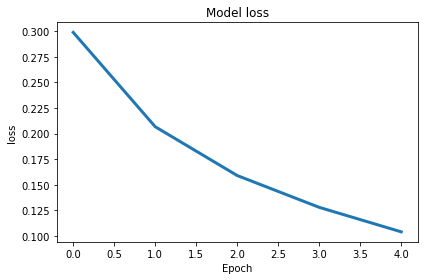

In [29]:
#plt.subplot(121)
plt.plot(history1.history['loss'], linewidth=3.0)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

#plt.subplot(122)
#plt.plot(history1.history['val_loss'], linewidth=3.0)
#plt.title('Model-Validation loss')
#plt.ylabel('val_loss')
#plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

### Fine Tuning the Aleph-bert Model

In [30]:
# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  125976576   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [31]:
############# Uncomment the validation data_data for the validation dataset
history2 = model.fit(
    train_data,
    # validation_data = val_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

Epoch 1/5


486/486 [==============================] - 413s 814ms/step - loss: 0.0912 - accuracy: 0.9673
Epoch 2/5
486/486 [==============================] - 395s 813ms/step - loss: 0.0496 - accuracy: 0.9831
Epoch 3/5
486/486 [==============================] - 395s 813ms/step - loss: 0.0353 - accuracy: 0.9885
Epoch 4/5
486/486 [==============================] - 395s 813ms/step - loss: 0.0259 - accuracy: 0.9913
Epoch 5/5
486/486 [==============================] - 395s 813ms/step - loss: 0.0219 - accuracy: 0.9933


Plot History

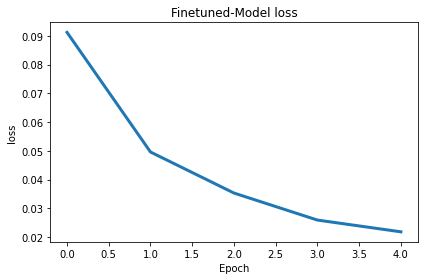

In [32]:
#plt.subplot(121)
plt.plot(history2.history['loss'], linewidth=3.0)
plt.title('Finetuned-Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

#plt.subplot(122)
#plt.plot(history2.history['val_loss'], linewidth=3.0)
#plt.title('Finetuned-Model-Validation loss')
#plt.ylabel('val_loss')
#plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

## Inference on Custom Dataset

In [33]:
def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data[0])[0]
    print("All probass",proba)
    idx = np.argmax(proba)
    print(idx)
    proba = f"{proba[idx]: .2f}"
    pred = labels[idx]
    return pred, proba

In [34]:
# sentences are positive
sentence1 = "מה אתה יודע לעשות?"
sentence2 = "מה הפעולות שאתה יודע לעשות?"
check_similarity(sentence1, sentence2)

1/1 [==============================] - 4s 4s/step
All probass [0.00258928 0.9974107 ]
1


('positive', ' 1.00')

In [35]:
# sentences are negative
sentence1 = "איך אתה מרגיש?"
sentence2 = "מה הביצועים שאת תומכת בהן?"
check_similarity(sentence1, sentence2)

1/1 [==============================] - 0s 102ms/step
All probass [9.993368e-01 6.632130e-04]
0


('negative', ' 1.00')

In [36]:
# sentences are negative
sentence1 = "אני חשה בודדה בעולם"
sentence2 =  "איזה חג אתה אוהב לחגוג?"
check_similarity(sentence1, sentence2)

1/1 [==============================] - 0s 100ms/step
All probass [0.9971367  0.00286324]
0


('negative', ' 1.00')

In [37]:
# sentences are positive
sentence1 = "תספרי לי איזו פעולות את יודעת לבצע?"
sentence2 = "מה הפעולות שאתה יודע לעשות?"
check_similarity(sentence1, sentence2)

1/1 [==============================] - 0s 108ms/step
All probass [5.2438663e-05 9.9994755e-01]
1


('positive', ' 1.00')

In [38]:
# sentences are negative
sentence1 = "איזה פעולות את יודעת לבצע?"
sentence2 =  "איך אתה מרגיש?"
check_similarity(sentence1, sentence2)

1/1 [==============================] - 0s 105ms/step
All probass [9.9964678e-01 3.5321814e-04]
0


('negative', ' 1.00')

## Saving the Trained Model along with the Architecture

In [39]:
model.save('alephbert_finetuned_model_v2')

Reproduce Plots

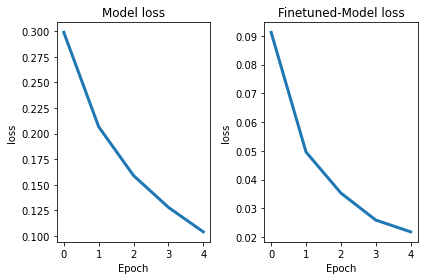

In [40]:
plt.subplot(121)
plt.plot(history1.history['loss'], linewidth=3.0)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

plt.subplot(122)
plt.plot(history2.history['loss'], linewidth=3.0)
plt.title('Finetuned-Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()
